## Lab 3.1 – Skin Cancer classification: MobileNet (Teachable Machine)

This notebook is used to evaluate the performance of skin cancer classification models trained on Teachable Machine.

Dataset consisting of 7 classes: Melanoma(MEL), Melanocytic nevi(NV), Basal cell carcinoma(BCC), Actinic keratoses(AKIEC), Benign keratosis lesions(BKL), Dermatofibroma(DF), and Vascular lesions(VASC)

This example code will consist of:

0. **Setup**
1. **Load Data**
2. **Load Model**
3. **Inference & Evaluate**

## 0) Setup
The code below install and import all required libraries and defines utility functions that will be used in the rest of this notebook.

In [1]:
# Download library
!pip install tensorflow==2.19.0

In [2]:
# Import library
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import DepthwiseConv2D
from keras.models import load_model

from PIL import Image, ImageOps
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

## 1) Load Data

In this step, the dataset is downloaded from GitHub. The directory structure is different from that used in Teachable Machine. Please refer to the following paths:
/content/images/ and /content/GroundTruth.csv

In [3]:
# Download Prepared dataset from github
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_torch.zip
!unzip -q -o 'Ham10000_torch.zip'

--2026-01-09 02:23:21--  https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_torch.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_torch.zip [following]
--2026-01-09 02:23:21--  https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_torch.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94841947 (90M) [application/zip]
Saving to: ‘Ham10000_torch.zip’

Ham10000_torch.zip  100%[===================>]  90.45M  41.6MB/s    in 2.2s    

2026-01-09 02:23:24 (41.6 M

In [4]:
# Load & Split dataset
df=pd.read_csv('/content/GroundTruth.csv')
df['image']=df['image'].apply(lambda x: "/content/images/"+x+ '.jpg')
df = df.drop(columns=["Unnamed: 0"])
df.head()

image  MEL  NV  BCC  AKIEC  BKL  DF  VASC
0  /content/images/ISIC_0024310.jpg    1   0    0      0    0   0     0
1  /content/images/ISIC_0024306.jpg    0   1    0      0    0   0     0
2  /content/images/ISIC_0024331.jpg    0   0    1      0    0   0     0
3  /content/images/ISIC_0024329.jpg    0   0    0      1    0   0     0
4  /content/images/ISIC_0024312.jpg    0   0    0      0    1   0     0

In [5]:
lesion_type_dict = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevi',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses',
    'BKL': 'Benign keratosis lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular lesions'
}

labels = list(df.columns[1:])
label_list=[]
full_label_list=[]
for i in range (len(df)):
    row= list(df.iloc[i])[1:]
    index=np.argmax(row)
    label=labels[index]
    label_list.append(label)

    full_label=lesion_type_dict[labels[index]]
    full_label_list.append(full_label)
df['label']= label_list
df['full_label']= full_label_list

train_df, val_df, test_df = df[:210], df[210:280], df[280:350]

print('Data Test:', len(test_df))
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

test_df.head()

Data Test: 70


image  MEL  NV  BCC  AKIEC  BKL  DF  VASC  \
0  /content/images/ISIC_0024767.jpg    1   0    0      0    0   0     0   
1  /content/images/ISIC_0024365.jpg    0   1    0      0    0   0     0   
2  /content/images/ISIC_0024949.jpg    0   0    1      0    0   0     0   
3  /content/images/ISIC_0025368.jpg    0   0    0      1    0   0     0   
4  /content/images/ISIC_0024705.jpg    0   0    0      0    1   0     0   

   label                full_label  
0    MEL                  Melanoma  
1     NV          Melanocytic nevi  
2    BCC      Basal cell carcinoma  
3  AKIEC         Actinic keratoses  
4    BKL  Benign keratosis lesions

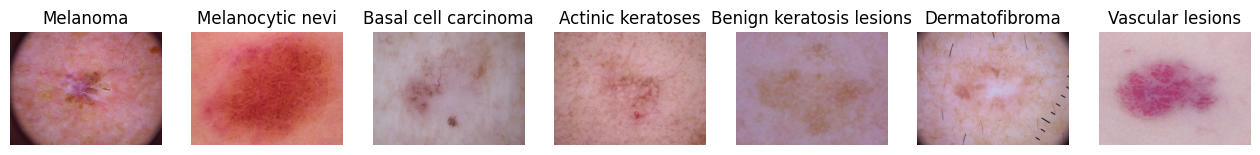

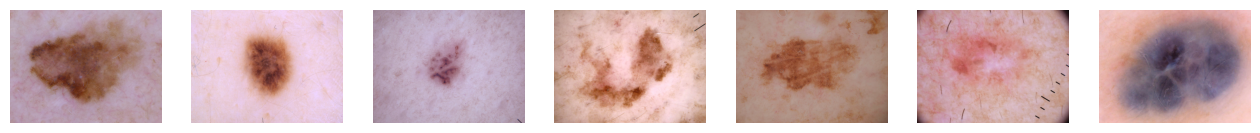

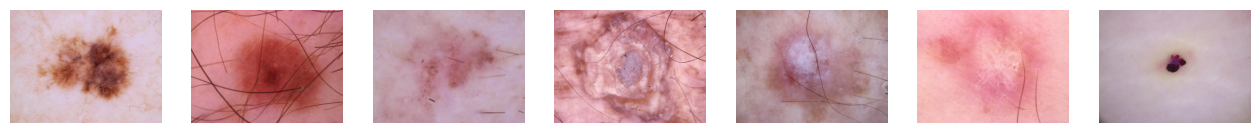

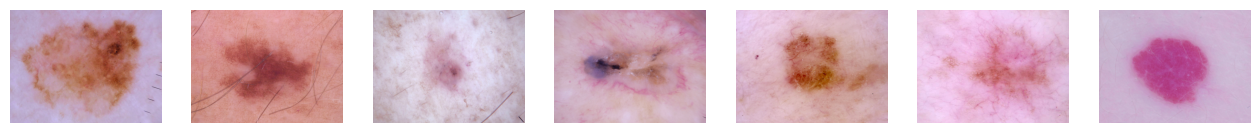

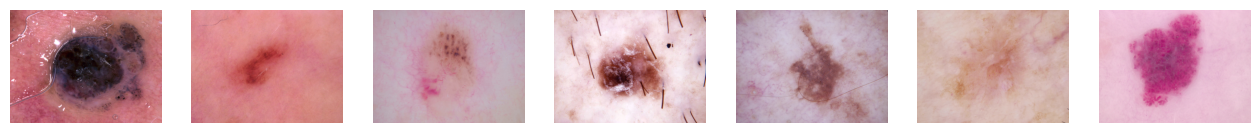

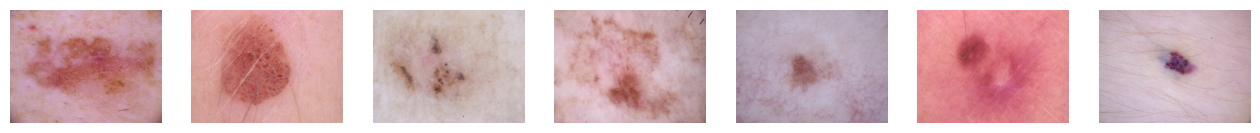

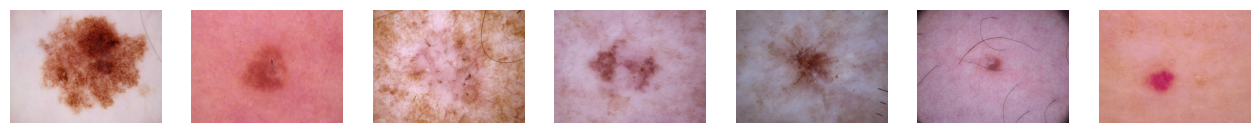

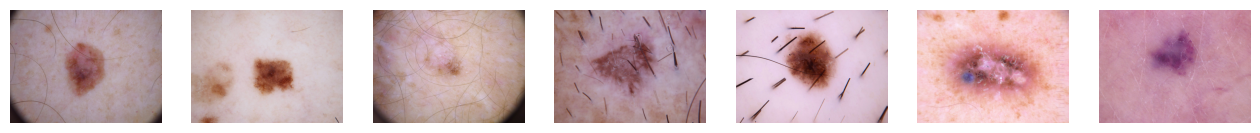

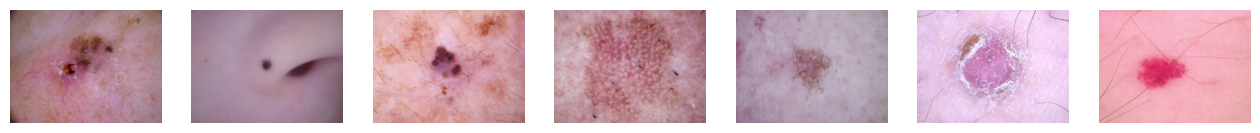

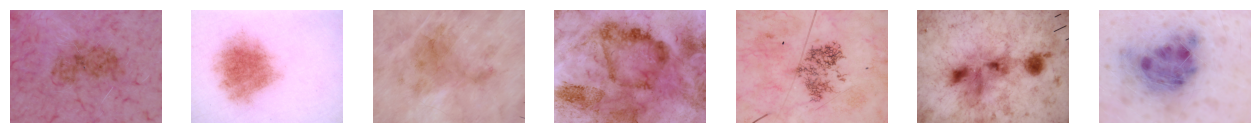

In [6]:
# Example image
for i in range(10):
  plt.figure(figsize=(16, 14))
  for j in range(7):
    plt.subplot(1,7,j+1)
    plt.imshow(mpimg.imread(test_df.image[j+(i*7)]))
    plt.axis("off")
    if not i:
      plt.title(test_df.full_label[j])

## 2) Load Model
Load models trained on Teachable Machine

The image model in Teachable Machine is MobileNet, which is built using TensorFlow.

In [7]:
# Upload the ZIP file exported from Teachable Machine, then unzip it.
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main//code/Class03_IntroDL/TM_keras.zip # Comment this line if you want to upload your own file.
!unzip -q -o 'TM_keras.zip'

--2026-01-09 02:23:30--  https://github.com/pvateekul/digitalhealth-ai2025/raw/main//code/Class03_IntroDL/TM_keras.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/code/Class03_IntroDL/TM_keras.zip [following]
--2026-01-09 02:23:31--  https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/code/Class03_IntroDL/TM_keras.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2457673 (2.3M) [application/zip]
Saving to: ‘TM_keras.zip’

TM_keras.zip        100%[===================>]   2.34M  15.4MB/s    in 0.2s    

2026-01-09 

In [8]:
np.set_printoptions(suppress=True)
class FixedDepthwiseConv2D(DepthwiseConv2D):
    def __init__(self, *args, **kwargs):
        kwargs.pop("groups", None)
        super().__init__(*args, **kwargs)

wegihts_path = "/content/keras_model.h5" # @param {type:"string"}
model = load_model(
    wegihts_path,
    custom_objects={"DepthwiseConv2D": FixedDepthwiseConv2D},
    compile=False
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 3) Inference & Evaluate

In [9]:
with open("labels.txt", "r") as f:
    class_names = [line.strip()[2:] for line in f.readlines()]
class_names

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [10]:
# Inference
output_list = []
confidence_score_list = []
for i in range(len(test_df)):

  data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
  # Replace this with the path to your image
  image = Image.open(test_df.image[i]).convert("RGB")
  # resizing the image to be at least 224x224 and then cropping from the center
  size = (224, 224)
  image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)
  # turn the image into a numpy array
  image_array = np.asarray(image)
  # Normalize the image
  normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1
  # Load the image into the array
  data[0] = normalized_image_array
  # Predicts the model
  prediction = model.predict(data)
  index = np.argmax(prediction)
  class_name = class_names[index]
  confidence_score = prediction[0][index]

  output_list.append(class_name)
  confidence_score_list.append(confidence_score)

test_df.loc[:, 'output'] = output_list
test_df.loc[:, 'confidence']= confidence_score_list

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━

In [11]:
test_df.head()

image  MEL  NV  BCC  AKIEC  BKL  DF  VASC  \
0  /content/images/ISIC_0024767.jpg    1   0    0      0    0   0     0   
1  /content/images/ISIC_0024365.jpg    0   1    0      0    0   0     0   
2  /content/images/ISIC_0024949.jpg    0   0    1      0    0   0     0   
3  /content/images/ISIC_0025368.jpg    0   0    0      1    0   0     0   
4  /content/images/ISIC_0024705.jpg    0   0    0      0    1   0     0   

   label                full_label output  confidence  
0    MEL                  Melanoma    BKL    0.728131  
1     NV          Melanocytic nevi    BKL    0.817548  
2    BCC      Basal cell carcinoma    BCC    0.979446  
3  AKIEC         Actinic keratoses    BCC    0.797852  
4    BKL  Benign keratosis lesions     DF    0.333881

In [12]:
# Evaluate
# Classification Report
report = classification_report(test_df.label, test_df.output, digits = 4)
M = confusion_matrix(test_df.label, test_df.output)
print(report)
disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=class_names)

              precision    recall  f1-score   support

       AKIEC     0.3333    0.2000    0.2500        10
         BCC     0.5455    0.6000    0.5714        10
         BKL     0.4118    0.7000    0.5185        10
          DF     0.6000    0.3000    0.4000        10
         MEL     0.4167    0.5000    0.4545        10
          NV     0.6667    0.6000    0.6316        10
        VASC     0.9000    0.9000    0.9000        10

    accuracy                         0.5429        70
   macro avg     0.5534    0.5429    0.5323        70
weighted avg     0.5534    0.5429    0.5323        70



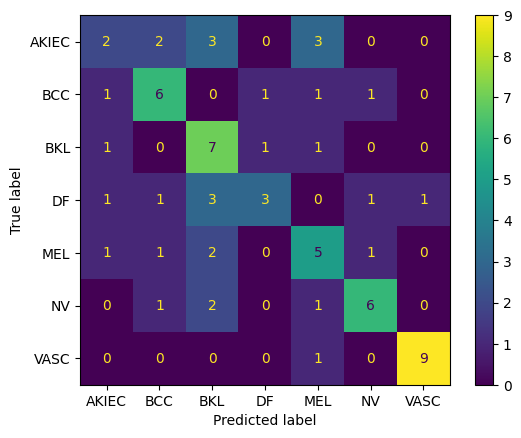

In [13]:
disp.plot()
plt.show()

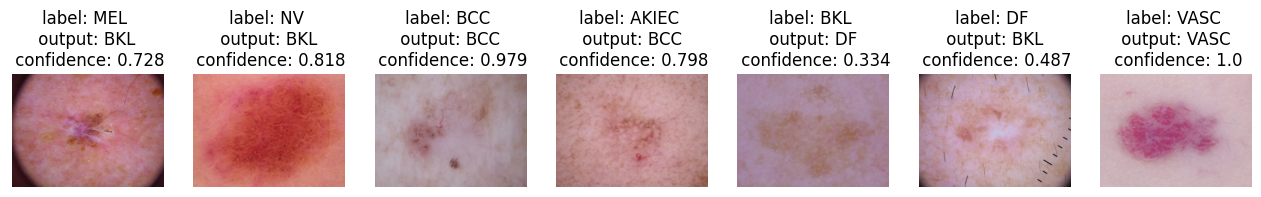

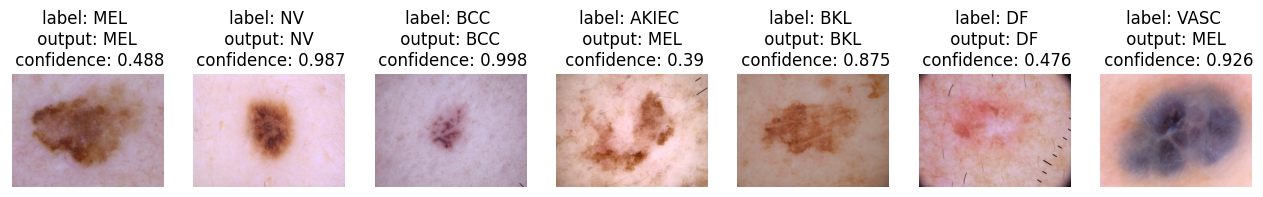

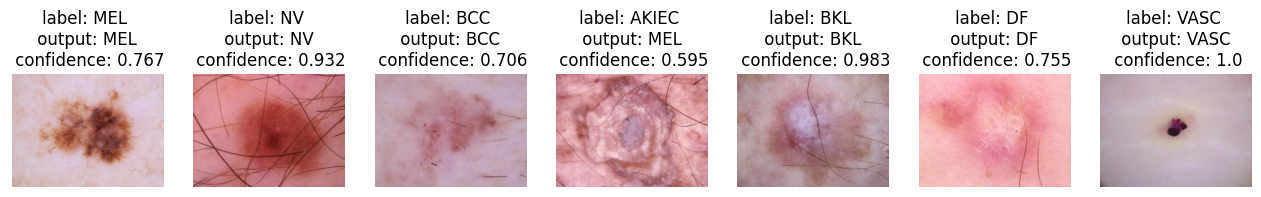

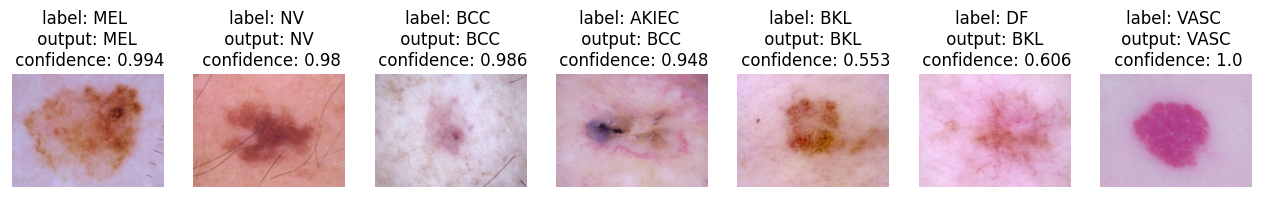

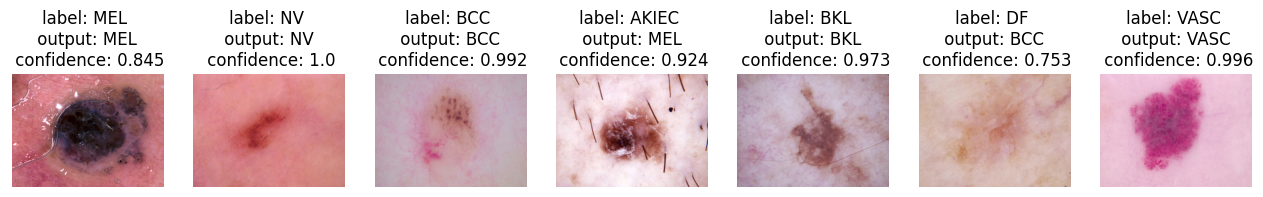

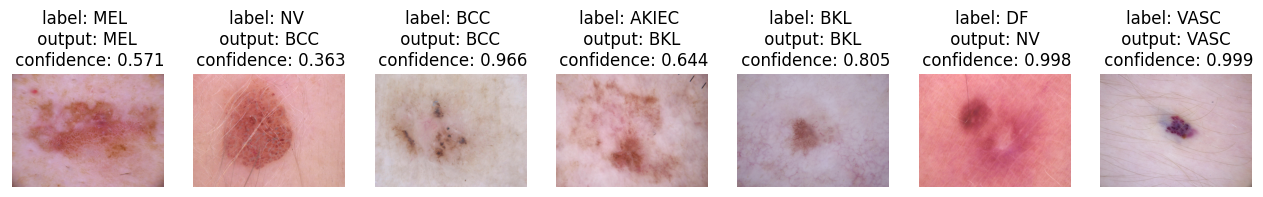

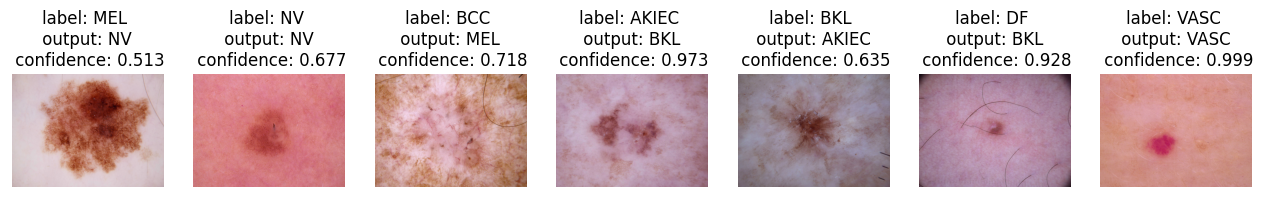

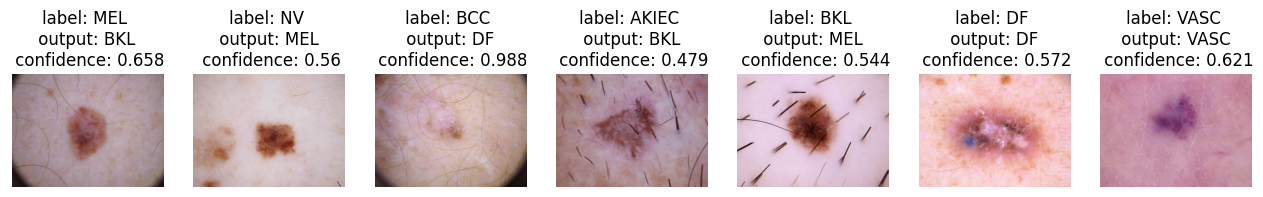

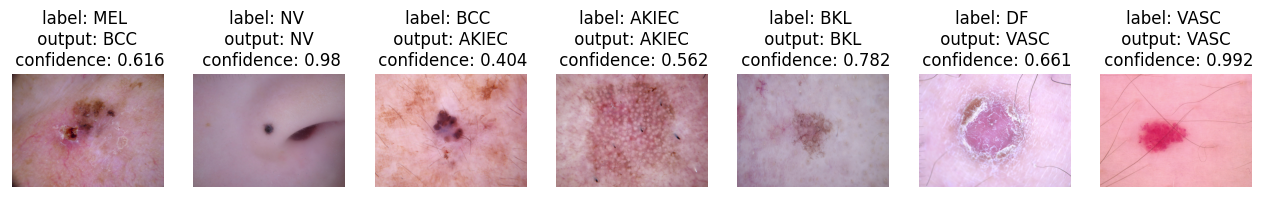

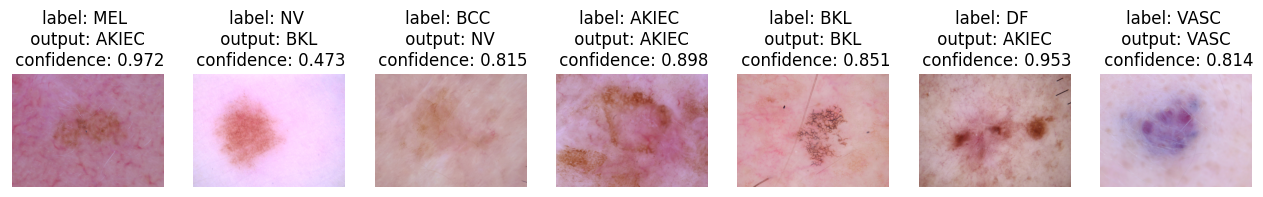

In [14]:
# Example image
for i in range(10):
  plt.figure(figsize=(16, 14))
  for j in range(7):
    plt.subplot(1,7,j+1)
    plt.imshow(mpimg.imread(test_df.image[j+(i*7)]))
    plt.axis("off")
    plt.title(f"label: {test_df.label[j+(i*7)]} \n output: {test_df.output[j+(i*7)]} \n confidence: {round(float(test_df.confidence[j+(i*7)]), 3)}")
